In [1]:
import requests
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
load_dotenv()

# CONFIGS
API_KEY = os.getenv("CONGRESS_API_KEY")
BASE_URL = "https://api.congress.gov/v3"

keywords = ["energy", "grid", "resources", "electric", "power", 
            "utility", "renewable", "transmission", "coal", 
            "solar", "wind", "battery"]

# checks if the word contains any of the keywords
def contains_keyword(text: str) -> bool:
  # returns True if any keyword is in the text
  if not isinstance(text, str):
    return False
  text_lower = text.lower()
  return any(k in text_lower for k in keywords)

# Generate monthly periods
def generate_periods(start_date, end_date, freq="quarter"):
    periods = pd.date_range(start=start_date, end=end_date, freq=freq).to_pydatetime().tolist()
    periods = [datetime.strftime(d, "%Y-%m-%d") for d in periods]
    # ensure end date is included
    if periods[-1] != end_date:
        periods.append(end_date)
    return periods

# fetches bill summaries from Congress API
def get_summaries(start, end, limit=250):
  url = f"{BASE_URL}/summaries"
  params = {
    "api_key": API_KEY,
    "fromDateTime": f"{start}T00:00:00Z",
    "toDateTime": f"{end}T23:59:59Z",
    "sort": "updateDate+desc",
    "limit": limit,
    "format": "json"
  }
  resp = requests.get(url, params=params)
  resp.raise_for_status()
  return resp.json().get("summaries", [])

def filter_bills(start_date="2018-01-01", end_date=None):
  if end_date is None:
    end_date = datetime.today().strftime("%Y-%m-%d")
    
  # generates periods quarterly
  periods = generate_periods(start_date, end_date, freq="3M")
  matched = []

  for i in range(len(periods) - 1):
    start = periods[i]
    end = periods[i+1]
    summaries = get_summaries(start, end)

    for s in summaries:
      # obtains information from the summaries
      bill = s.get("bill", {})
      title = bill.get("title", "")
      text = s.get("text", "")
      # checks keywords in both title and summary text
      if contains_keyword(title) or contains_keyword(text):
        matched.append({
          "introduced_date": s.get("actionDate"),
          "action_desc": s.get("actionDesc"),
          "chamber_origin": bill.get("originChamber"),
          "chamber_current": s.get("currentChamber"),
          "title": title,
          "summary_text": text,
          "congress": bill.get("congress"),
          "bill_id": f"{bill.get('congress')}-{bill.get('type')}{bill.get('number')}",
          "type": bill.get("type"),
          "number": bill.get("number"),
          "url": bill.get("url"),
          "update_date": s.get("updateDate"),
          "last_summary_update": s.get("lastSummaryUpdateDate")
        })

  # converts list to dataframe
  bills_df = pd.DataFrame(matched)
  # stores times/dates as datetime
  bills_df["introduced_date"] = pd.to_datetime(bills_df["introduced_date"])
  bills_df["update_date"] = pd.to_datetime(bills_df["update_date"], errors="coerce")

  # remove exact duplicates
  bills_df = bills_df.drop_duplicates(subset=["bill_id", "update_date"])

  return bills_df.sort_values(by="introduced_date")

# filter bills for energy-related words
bills_df = filter_bills()
# filter df because it returns all available results... (back to 1993)
bills_df = bills_df[bills_df['introduced_date'] >= pd.to_datetime("2018-01-01")]
# display(bills_df)
# bills_df.to_csv("bills_energy.csv", index=False)

/var/folders/m8/81ptgb3x7j755glt7xp0jptc0000gn/T/ipykernel_59485/1087802720.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  periods = pd.date_range(start=start_date, end=end_date, freq=freq).to_pydatetime().tolist()


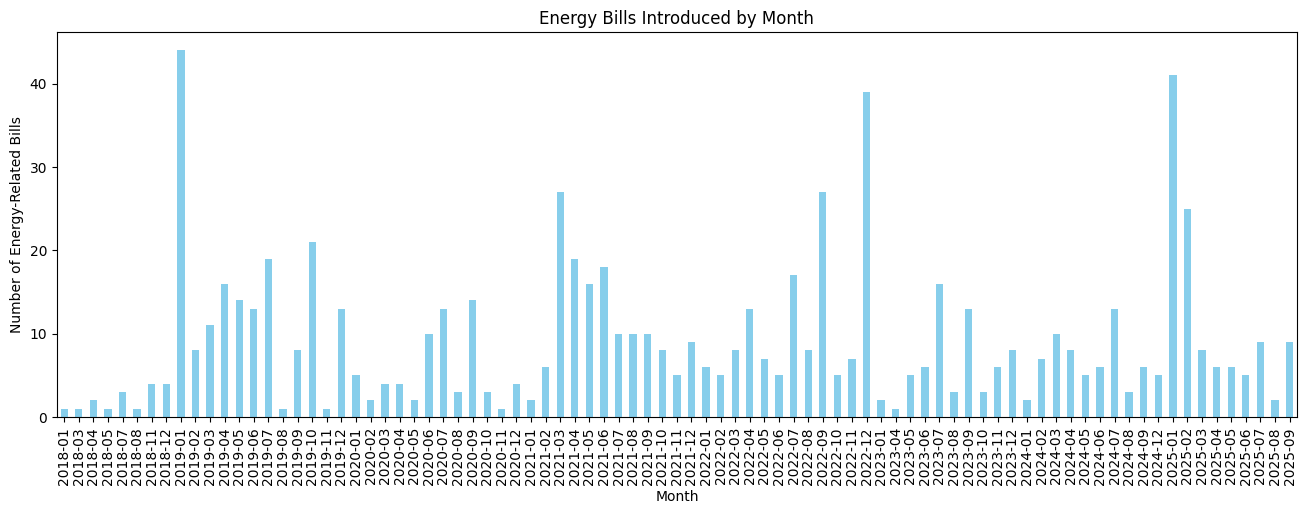

In [2]:
# time series trend

#####
# MAJOR PEAKS in December/January and occassionally trailing into February/March
#####
### December/January: new Congress begins on January 3rd; legislators rush to introduce bills 
# before session ends; energy bills are often introduced early in the year to align with
# other priorities (e.g. infrastructure plans, budget cycles, season energy...)

### February: right after new president was inaugurated/early-year legislative momentum;
# start of congressional calendar; strategic window to influence DOE, EPA, and federal energy 
# programs for the coming year; events bring together utilitis and energy companies...
#  NASEO Energy Policy Outlook Conference and  NARUC Winter Policy Summit; Winter months may 
# have exposed energy reliability or energy concerns...

#####
# MINOR PEAKS in July and September
######
### July: Coincides with the beginning of the federal fiscal year; July 4th
# sets agenda for the second half of the year; more bill activity before summer recess;
# mid-year legislation aligns with corporate planning cycles

### September: US federal fiscal year ends at the end of September; Congress aims to finalize budgets,
# appropriations, and incentives; federal agencies (e.g. DOE, Interior, EPA) aim to issue final rules
# or policy clarifications in September to avoid carrying over tasks into the next fiscal year;
# pre-winter energy planning (emergency preparedness bills, grid reliability plans, energy supply measures);
# last month before midterm election campaigns- administration may accelerate policy decisions to
# demonstrate results


bills_df['year_month'] = bills_df['introduced_date'].dt.to_period('M')
month_counts = bills_df['year_month'].value_counts().sort_index()
month_counts.plot(kind='bar', figsize=(16,5), color='skyblue')
plt.xlabel("Month")
plt.ylabel("Number of Energy-Related Bills")
plt.title("Energy Bills Introduced by Month")
plt.show()

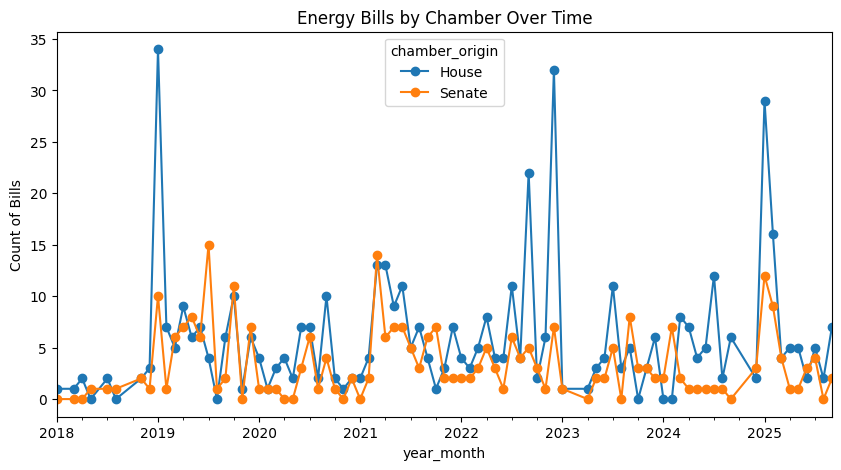

In [ ]:
# Policy Momentum Indicators

# Major spikes in January of 2019, 2023, 2025
# Smaller spikes in early 2021, mid-2022, and late 2024
# Spikes align with the start of new Congress sessions
## every two years... 116th (2019), 118th (2023), 119th (2025)
# House tends to leard with early-year peaks; Senate follows

# There is often a burst of activity in energy-related bills every January-March in odd-numbered years
## new Congress start; committee assignments reset; priority-setting for DOE, FERC, EPA, and interior budgets

# Insight: grid and energy policy landscape is heavily influenced by new Congress sessions
# Insight: predictive focus should align with odd-numbered years (b.c. changing legislative priorities)
bills_df.groupby(['year_month','chamber_origin']).size().unstack(fill_value=0).plot(
    kind='line', figsize=(10,5), marker='o'
)
plt.title("Energy Bills by Chamber Over Time")
plt.ylabel("Count of Bills")
plt.show()

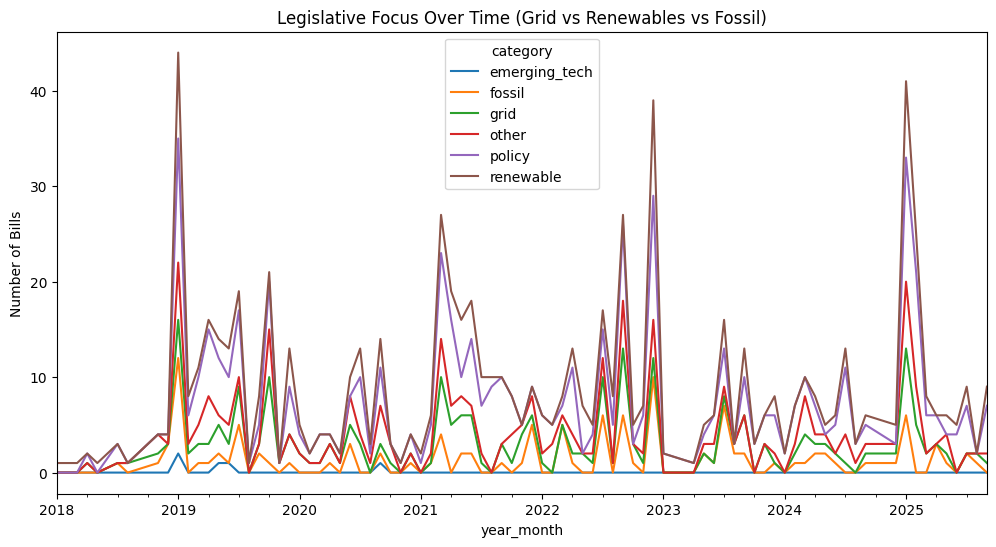

In [ ]:
# Bills by Topic

# Peaks coincide with analysis above!!
# Policy and renewable categories dominate;
# occasional spikes in fossil and grid (likely during crisis or infrastructure debates)

# Grid: after reliability failures (Texas 2021 freeze, 2022 summer outages)
# Renewable: peaks after major infrastructure and climate pushes
### Green New Deal (2019-2020), Infrastruture Investment and Jobs Act (IIJA) and IRA (2021-2022)

# Insight: policy direction has focused more on renewables and grid modernization since 2021
# Insight: Expect increasing policy density around grid resilience and energy storage rather than fossil expansion

categories = {
    "renewable": [
        "renewable", "solar", "wind", "hydro", "hydropower", "geothermal",
        "biomass", "bioenergy", "tidal", "wave energy", "rooftop solar",
        "community solar", "solar farm", "wind farm", "offshore wind", 
        "onshore wind", "distributed generation", "photovoltaic", "PV",
        "green energy", "clean energy", "net zero", "carbon neutral",
        "decarbonization", "emissions-free", "fuel cell", "green hydrogen"
    ],
    "fossil": [
        "coal", "oil", "natural gas", "fossil fuel", "petroleum", "fracking",
        "shale", "diesel", "gasoline", "methane", "propane", "butane",
        "tar sands", "bitumen", "refinery", "drilling", "extraction",
        "strip mining", "offshore drilling", "fossil generation", 
        "peaker plant", "liquefied natural gas", "LNG", "pipeline"
    ],
    "grid": [
        "grid", "transmission", "distribution", "utility", "powerline", 
        "infrastructure", "substation", "transformer", "reliability", 
        "resilience", "blackout", "outage", "restoration", "dispatch",
        "control center", "frequency regulation", "congestion", 
        "interconnection", "capacity market", "load balancing", 
        "demand response", "smart grid", "microgrid", "islanding", 
        "ancillary services", "high-voltage", "intertie", 
        "MISO", "PJM", "ERCOT", "CAISO", "NYISO"
    ],
    "policy": [
        "FERC", "DOE", "EPA", "EIA", "appropriation", "federal", "state", 
        "regulation", "legislation", "rulemaking", "executive order", 
        "mandate", "subsidy", "tax credit", "ITC", "PTC", "IRA", 
        "infrastructure bill", "clean energy standard", "CES", 
        "renewable portfolio standard", "RPS", "climate policy", 
        "carbon tax", "cap-and-trade", "emissions target", "compliance",
        "grant", "funding", "incentive", "energy security"
    ],
    "emerging_tech": [
        "fusion", "modular reactor", "SMR", "advanced nuclear", "thorium",
        "quantum battery", "solid-state battery", "long-duration storage",
        "compressed air storage", "flow battery", "AI optimization",
        "machine learning", "blockchain energy", "vehicle-to-grid", "V2G",
        "virtual power plant", "carbon removal", "direct air capture",
        "synthetic fuel", "e-fuel", "ammonia fuel", "hydrogen hub",
        "grid-forming inverter", "power-to-x", "digital twin"
    ]
}

def categorize(text):
  text = text.lower()
  for cat, kws in categories.items():
    if any(k in text for k in kws):
      return cat
  return "other"

# categorize by summary_text
bills_df['category'] = bills_df['summary_text'].apply(categorize)
bills_df.groupby(['year_month','category']).size().unstack(fill_value=0).plot(
    kind='line', stacked=True, figsize=(12,6)
)
plt.title("Legislative Focus Over Time (Grid vs Renewables vs Fossil)")
plt.ylabel("Number of Bills")
plt.show()

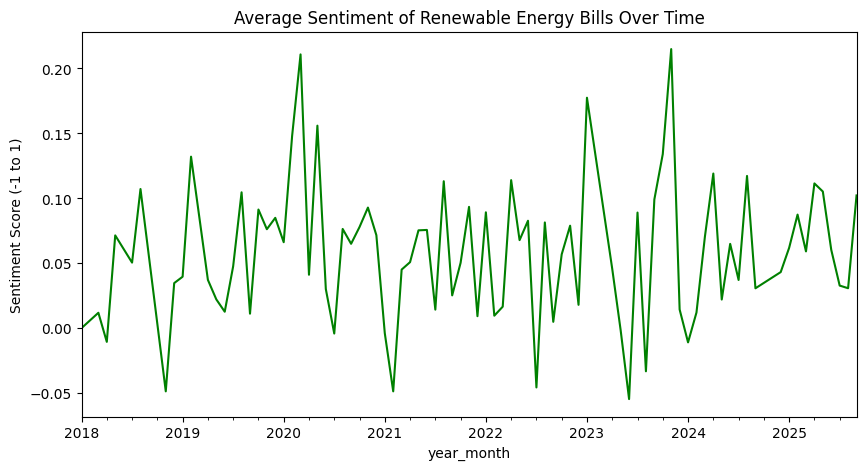

In [ ]:
# Sentiment Analysis on the Summaries
# positive sentiment: supportive for renewable energy or grid upgrades
# negative sentiment: restrictive legislation or fossil-fuel-friendly policy

# Overall sentiment remains positive (0.05 - 0.20), meaning renewable energy bills
# are framed optimistically... indicating a focus on innovation, investment, growth
# Dips may reflect policy pushback or funding disputes

# Insight: sentiment towards renewable energy is mainly favorable

from textblob import TextBlob

bills_df['sentiment'] = bills_df['summary_text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x,str) else 0)

monthly_sentiment = bills_df.groupby('year_month')['sentiment'].mean()
monthly_sentiment.plot(kind='line', figsize=(10,5), color='green')
plt.title("Average Sentiment of Renewable Energy Bills Over Time")
plt.ylabel("Sentiment Score (-1 to 1)")
plt.show()

/Users/colleenl/CSProjects/XTERNproject/xtern-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/colleenl/CSProjects/XTERNproject/xtern-venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


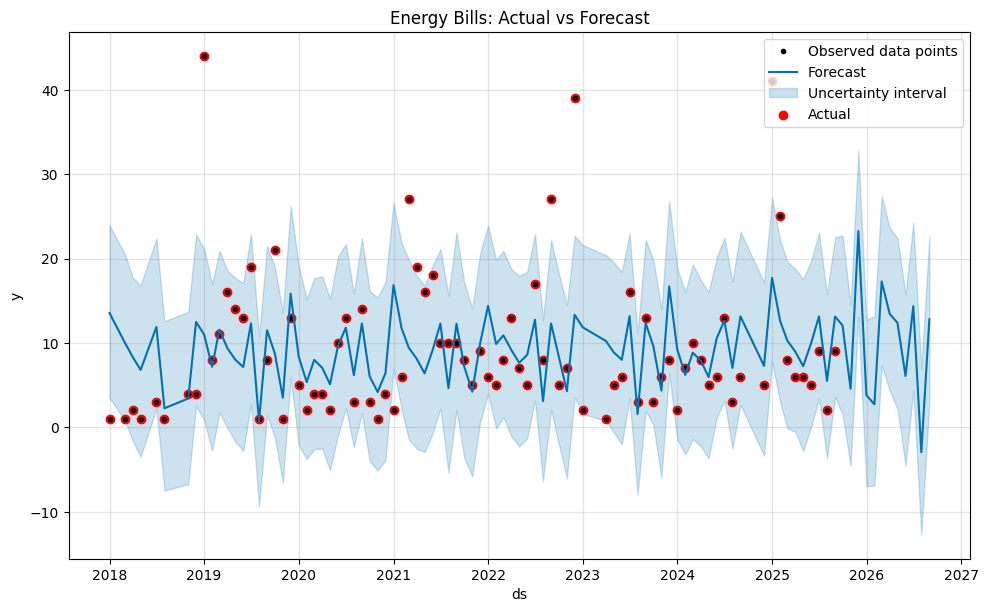

21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/colleenl/CSProjects/XTERNproject/xtern-venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


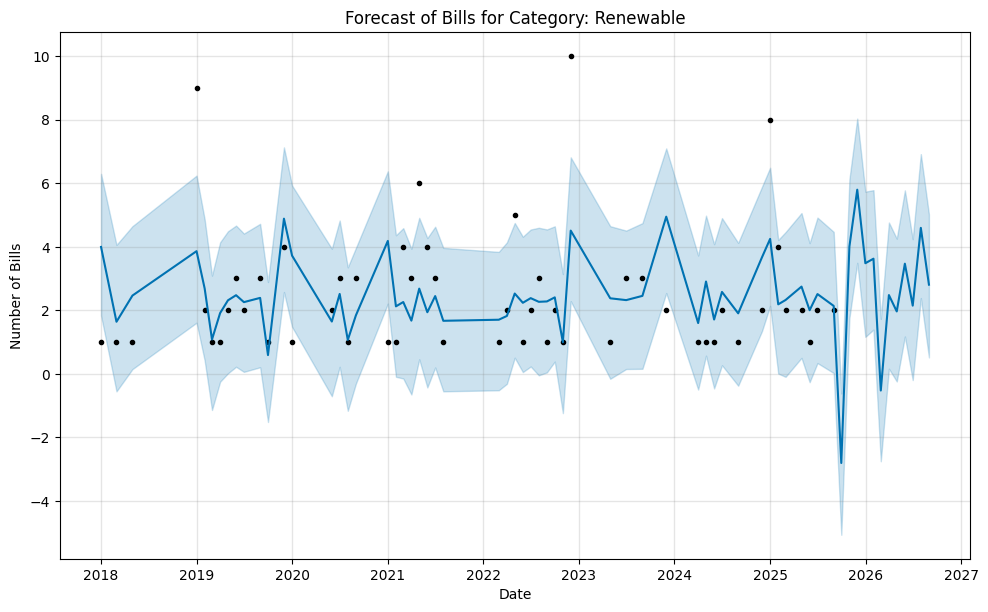

21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/colleenl/CSProjects/XTERNproject/xtern-venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


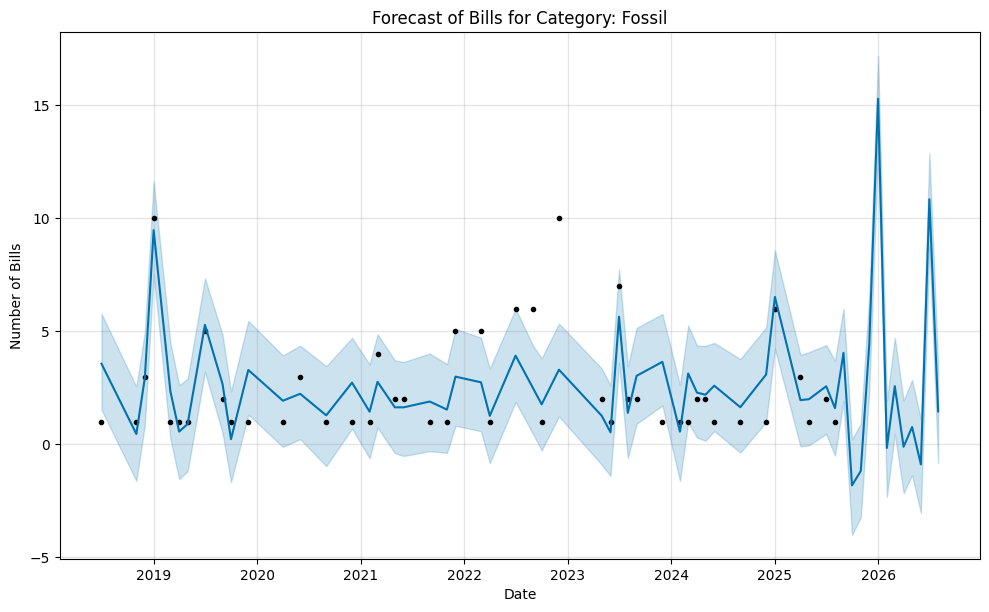

21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/colleenl/CSProjects/XTERNproject/xtern-venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


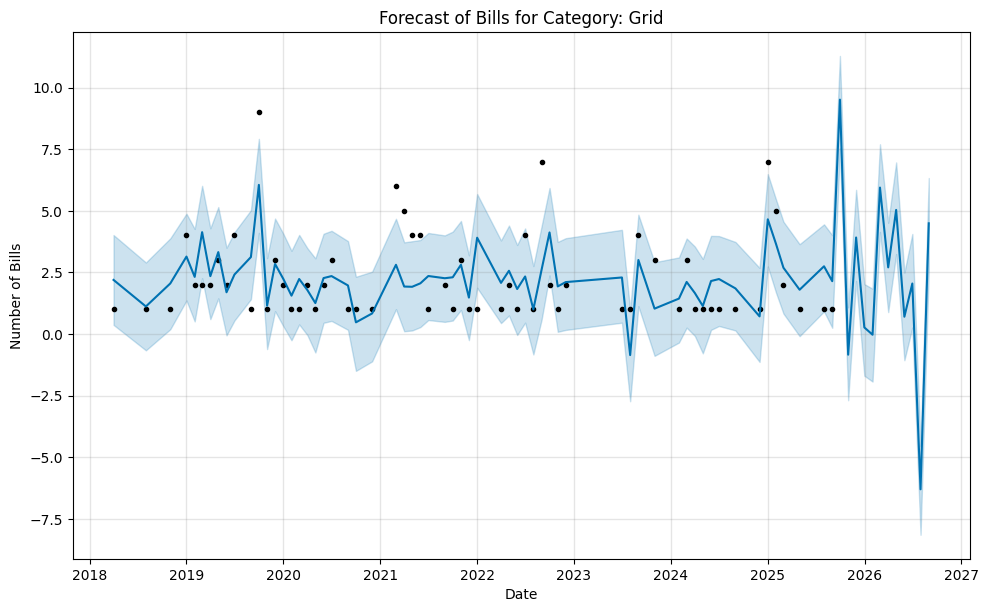

In [ ]:
# Predictive Modeling
# Future bill volume

# Energy Bills... Actual vs Forecast
## Re-emphasizes on the cyclicality of energy bill activity: 
# bursts in early-year sessions and pre-election periods
## Forecast indicates stable or slightly upward trajectory
# in total energy-related bills
## Uncertainty widens post-2025... unknowns from new administration
# or congressional control

# Insight: policy activity is expected to remain elevated through 2026

from prophet import Prophet

# prepare data for prophet
ts = month_counts.reset_index()
ts.columns = ['ds','y']
ts['ds'] = ts['ds'].dt.to_timestamp()

m = Prophet()
m.fit(ts)

# predicts 12 months ahead
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# plots forecast
m.plot(forecast)
plt.scatter(ts['ds'], ts['y'], color='red', label='Actual')
plt.title("Energy Bills: Actual vs Forecast")
plt.legend()
plt.show()

# category-specific
for cat in ['renewable', 'fossil', 'grid']:
    # filter by category and aggregate monthly counts
    ts_cat = bills_df[bills_df['category'] == cat].groupby('year_month').size().reset_index(name='y')
    ts_cat['ds'] = ts_cat['year_month'].dt.to_timestamp()
    
    if ts_cat.empty:
        print(f"No data for category: {cat}")
        continue
    
    # fit Prophet model
    m = Prophet()
    m.fit(ts_cat)
    
    # make future dataframe for next 12 months
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)
    
    # plot forecast
    fig = m.plot(forecast)
    plt.title(f"Forecast of Bills for Category: {cat.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Number of Bills")
    plt.show()

# Renewable Forecast
## Stable, slightly increasing through 2026... with variability
# Peaks hint at potential policy renewals or subsidy every 2 years

# Insight: expect continued legislative pressure for reneable integration

# Fossil Forecast
## Declining long-term trend, but occasional rebounds

# Insight: fossil legislation remains active but mainly during
# energy price surge, crisis, new administration

# Grid Forecast
## Stable and consistent; slight upward trend after 2024